# Modelling of physical systems

## Second Assignment

### Miłosz Góralczyk

## convergence analysis of the upwind scheme

The upwind scheme is a numerical method for solving Partial Differential Equations - PDE's, particularly for advection problems, where a quantity is transported by a flow. It is a finite difference method that considers the direction of wave propagation, making it more stable than other methods like central differences.

The equation to solve is the linear advection equation:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$

with:

  - u(x,t) - quantity being advected,
  - c - advection speed,
  - x - spatial coordinate,
  - t - time.

### A Practical Example

**Transport of a Pollutant in a River**

Suppose a pollutant is released at $x=0$ at time $t=0$.

The river carries the pollutant downstream at a speed $c$.

The pollutant concentration at any later time t is found by shifting the initial concentration profile downstream by $x=c$.

If you measure at a moving boat traveling at the same speed $c$, the concentration appears constant.


### Upwind Discretization

A numerical solution to approximating the value of advection PDE. As we cannot solve the PDE exactly in most cases, we convert derivatives int ofinite differences at discrete points in space and time. As usual, numerical solution lets us calculate the solution with computers, that handle finite values.

The proces of step-by-step numerical integration is called Finite Difference Method - FDM, which can - in our case -  be written as:

$$
  u^{{n}+1}_{i} = {u}^{n}_{i} - \left[F\left({u}^{n}_{i},  {u}^{n}_{{i}+1}, {C}\right)-F\left({u}^{n}_{{i}-1},{u}^{n}_{i}, {C}\right)\right]
$$

in a clearly recursive manner, which allows us to calculate the n-th step using (n-1)-th result, all the way from the initial conditions.

  - n - $\frac{t}{\Delta t}$ - time step
  - i - $\frac{x}{\Delta x}$ - space step
  - C - ${u}\frac{\Delta t}{\Delta x}$ - Courant number, Advection's Constant.
  - $u_{i}^{n}$ - the solution at spatial point $x_i$ and time $t_n$
  - $F\left({u}^{n}_{i},  {u}^{n}_{{i}+1}, {C}\right)$ - defined during classes function averaging values of two solutions' scalars.

With that theory, we can implement the numerical and analytical solutions, importing some of the code from the classes:

In [151]:
# imports
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot

In [152]:
# helper classes and solver functions
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)
    
class One:
    def __radd__(self, other):
        return slice(other.start+1, other.stop+1, 1)
    
    def __rsub__(self, other):
        return slice(other.start-1, other.stop-1, 1)


def F(L, R, C):
    return .5 * (C + abs(C)) * L + .5 * (C - abs(C)) * R


In [153]:
# conditions and parameters for both solvers
psi_0 = Psi_0()
nx = 64

x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
t_max = 50

u = 2
nt = 16
one = One()
dt = t_max / nt
C = u * dt / dx
i = slice(1, nx-2)
psi = psi_0(x)

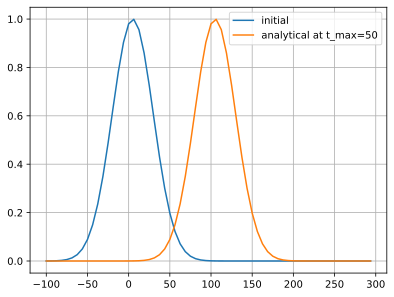

In [154]:
# plot of analytical solution
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

In [155]:
# numerical solution 
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

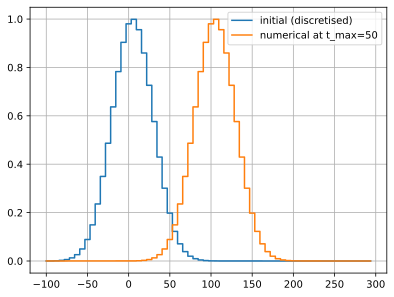

In [156]:
# plot of numerical solution
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical at {t_max=}', where='mid')
pyplot.legend()
pyplot.grid()

### An Overview of the approaches

####  Advantages of Analytical Solutions
- Exact for all points, with no approximation errors.
- Provides insight into the nature of the solution like wave propagation or stability.
- No numerical errors like truncation or discretization errors.

####  Disadvantages of Analytical Solutions
- Limited to simple PDEs and specific conditions.
- Real-world problems with turbulence or nonlinear parameters often have no closed-form solutions.


####  Advantages of Numerical Solutions
- Handles complex problems where no exact solution exists.
- Applicable to real-world problems like weather models, computational fluid dynamics.
- Works for nonlinear PDEs.

####  Disadvantages of Numerical Solutions
- Approximate introduces discretization error - analasing which is the goal of this assignment
- Computational cost increases with finer grids.
- Requires correct time-stepping to deal with stability issues.

## Analytial/Numerical Analysis

The goal of which is to calculate and plot the differences between the numerical solution and actual values.

Hopefully showing how the value of Courant number affects the Square Error of the actual value.

The results will be calculated on same-condition example, and plotted together for comparison

In [157]:
# Define spatial resolution range and Courant numbers for testing
dx_values = np.linspace(0.1, 10, 666)  
u_velocity = 1.5  

courant_numbers = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]  

In [158]:
# Root Mean Squared Error Calculation
def compute_rmse(numerical, analytical):
    return np.sqrt(np.mean((numerical - analytical) ** 2))

In [159]:
# Upwind scheme for advection equation
def upwind_advection(grid, velocity, courant, dx):
    dt = courant * dx / velocity  
    n_t = int(t_max / dt)  
    n_x = grid.shape[0]  

    psi = psi_0(grid)  # Initial condition
    i = np.arange(1, n_x - 2)  
    dC = velocity * dt / dx  # Effective Courant number

    for _ in range(n_t):
        psi[i] -= (F(psi[i], psi[i + 1], dC) - F(psi[i - 1], psi[i], dC))
    return psi

In [160]:
# Compute RMSE for different dx values
def compute_errors(x_range, velocity, courant, dx_values):
    rmse_results = np.array([])  

    for dx in dx_values:
        num_points = int((x_range[-1] - x_range[0]) / dx)
        grid = np.linspace(x_range[0], x_range[-1], num_points, endpoint=False)  

        numerical_solution = upwind_advection(grid, velocity, courant, dx)  
        analytical_solution = psi_0(grid - velocity * t_max)  

        rmse_results = np.append(rmse_results, compute_rmse(numerical_solution, analytical_solution))  

    return rmse_results  

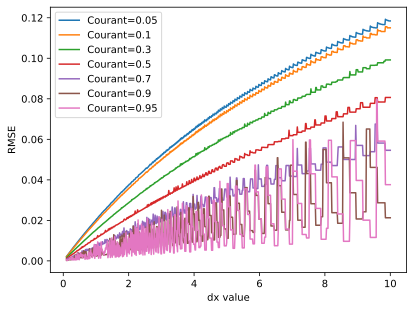

In [161]:
for c in courant_numbers: # for each courant number
    errors = compute_errors(x, u, c, dx_values)
    pyplot.plot(dx_values, errors, label=f'Courant={c}')
    pyplot.xlabel('dx value')
    pyplot.ylabel('RMSE')
    pyplot.legend()
show_plot(filename='advection_errors.png')

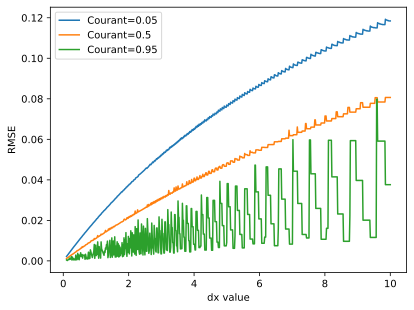

In [162]:
for c in courant_numbers[::3]: # for 0.05, 0.5, 0.95
    errors = compute_errors(x, u, c, dx_values)
    pyplot.plot(dx_values, errors, label=f'Courant={c}')
    pyplot.xlabel('dx value')
    pyplot.ylabel('RMSE')
    pyplot.legend()
show_plot(filename='advection_errors_min_mean_max.png')

##  Results and Conclusions  

The convergence analysis of the upwind scheme reveals distinct behaviors in RMSE depending on the Courant number.  

1. Low Courant Numbers (C = 0.05 - 0.1)  
- RMSE over dx follows a smooth logarithmic-like decay.  
- Highest RMSE observed at C = 0.05, reaching a steady value of 0.1 at dx = 10.  
- The method remains stable but exhibits lower overall accuracy compared to higher C values.  

2. High Courant Numbers (C = 0.9 - 0.95)  
- RMSE has a lower mean value, resulting in better accuracy on average.  
- However, numerical instability increases, creating a staircase-like pattern in the error graph.  
- For C = 0.95, RMSE oscillates between 0.066 (upper bound) and 0.01 (lower bound), with a mean of ≈0.03.  

3. Averaging Courant Number (C = 0.5)  
- The error remains continuous, with minimal oscillations.  
- RMSE fluctuations stay within a 5% range, maintaining stability.  
- The mean RMSE is ≈0.06, balancing accuracy and numerical stability.  

### Conclusion  
- Lower C values ensure stability but suffer from higher RMSE.  
- Higher C values reduce mean RMSE but introduce numerical oscillations.  
- C = 0.5 provides the best compromise, maintaining stability while achieving a reasonable error margin.

The results highlight the trade-off between accuracy and stability in numerical schemes, making C ≈ 0.5 a practical choice for balancing both in modelling of upwind scheme advection.